# **Detecção de Outliers em Séries Temporais com LSTM Autoencoder**

**Autor**: Renan Santos Mendes

**Email**: renansantosmendes@gmail.com

**Descrição** Este notebook implementa um autoencoder baseado em LSTM para detectar anomalias em dados de preços de ações. O modelo aprende a reconstruir padrões normais e identifica outliers através do erro de reconstrução.

**Versão melhorada** com ajustes para melhor convergência:
- MinMaxScaler ao invés de StandardScaler
- Modelo com maior capacidade (mais camadas e neurônios)
- Learning rate scheduler adaptativo
- Múltiplas features (Close, Volume, High, Low)
- Early stopping para evitar overfitting

## **Importação das Bibliotecas**

Importamos todas as bibliotecas necessárias para o projeto: PyTorch para o modelo de deep learning, yfinance para coleta de dados financeiros, e bibliotecas auxiliares para manipulação e visualização de dados.

In [1]:
import os
import random
import joblib
from typing import Tuple, List, Dict, Any, Union

import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split

## **Configuração do Dispositivo**

Verificamos se há uma GPU disponível para acelerar o treinamento do modelo. Caso contrário, utilizamos a CPU.

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## **Hiperparâmetros**

Centralizamos todos os hiperparâmetros em um único lugar para facilitar a experimentação. Os valores foram otimizados para melhor convergência.

In [3]:
TICKER = "AAPL"
START_DATE = "2020-01-01"
END_DATE = "2025-12-01"

SEQUENCE_LENGTH = 30
BATCH_SIZE = 64
HIDDEN_DIM = 64
LATENT_DIM = 16
NUMBER_OF_LAYERS = 2
DROPOUT_RATE = 0.2

LEARNING_RATE = 1e-3
NUMBER_OF_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 12
TRAIN_VALIDATION_SPLIT = 0.8

OUTLIER_PERCENTILE = 95

## **Coleta de Dados**

Utilizamos a biblioteca yfinance para baixar os dados históricos de preços. Nesta versão melhorada, coletamos múltiplas features (Close, High, Low, Volume) para dar mais contexto ao modelo.

In [4]:
def download_stock_data(
    ticker: str,
    start_date: str,
    end_date: str
) -> pd.DataFrame:
    """
    Download stock data from Yahoo Finance.

    Args:
        ticker: Stock ticker symbol.
        start_date: Start date for data retrieval in YYYY-MM-DD format.
        end_date: End date for data retrieval in YYYY-MM-DD format.

    Returns:
        DataFrame containing the stock data.
    """
    print("Downloading data...")
    dataframe = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=False
    )
    return dataframe


def engineer_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Create engineered features from raw stock data.

    Args:
        dataframe: Raw stock data DataFrame.

    Returns:
        DataFrame with additional engineered features.
    """
    dataframe["LogVolume"] = np.log1p(dataframe["Volume"].fillna(0))
    dataframe["Return"] = dataframe["Close"].pct_change().fillna(0)
    dataframe["HighLowSpread"] = (
        (dataframe["High"] - dataframe["Low"]) / dataframe["Close"]
    ).fillna(0)
    return dataframe



## **Preparação dos Dados**

Utilizamos MinMaxScaler para normalizar os dados entre 0 e 1, o que geralmente funciona melhor para séries temporais financeiras. Em seguida, criamos sequências de janela deslizante.

In [5]:
def create_sequences_and_targets(
    data: np.ndarray,
    sequence_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create input sequences and corresponding target values.

    Args:
        data: Normalized feature array.
        sequence_length: Number of timesteps in each input sequence.

    Returns:
        Tuple containing input sequences (X) and target values (y).
    """
    input_sequences: List[np.ndarray] = []
    target_values: List[np.ndarray] = []

    for index in range(len(data) - sequence_length):
        input_sequences.append(data[index:index + sequence_length])
        target_values.append(data[index + sequence_length])

    return np.array(input_sequences), np.array(target_values)

## **Dataset Customizado**

Criamos uma classe Dataset do PyTorch para encapsular nossas sequências temporais, permitindo o carregamento eficiente dos dados durante o treinamento.

In [6]:
class TimeSeriesForecastDataset(Dataset):
    """
    PyTorch Dataset for time series forecasting.

    Attributes:
        input_sequences: Tensor of input sequences with shape (n_samples, seq_length, n_features).
        target_values: Tensor of target values with shape (n_samples, n_features).
    """

    def __init__(self, input_sequences: np.ndarray, target_values: np.ndarray) -> None:
        """
        Initialize the dataset.

        Args:
            input_sequences: Array of input sequences.
            target_values: Array of target values.
        """
        self.input_sequences: torch.Tensor = torch.FloatTensor(input_sequences)
        self.target_values: torch.Tensor = torch.FloatTensor(target_values)

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.input_sequences)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get a sample from the dataset.

        Args:
            index: Index of the sample to retrieve.

        Returns:
            Tuple containing input sequence and target value tensors.
        """
        return self.input_sequences[index], self.target_values[index]

## **Arquitetura do LSTM Autoencoder**

Esta versão do modelo possui maior capacidade com múltiplas camadas LSTM, dropout para regularização, e batch normalization para estabilizar o treinamento.

In [7]:
class ForecastLSTMAutoencoder(nn.Module):
    """
    LSTM Encoder with Multi-Head Attention and Decoder for time series forecasting.

    This model encodes input sequences using an LSTM, applies multi-head attention
    between a latent representation and encoder outputs, then decodes to predict
    the next timestep.

    Attributes:
        sequence_length: Length of input sequences.
        input_dimension: Number of input features.
        hidden_dimension: Size of LSTM hidden state.
        latent_dimension: Size of latent representation.
        number_of_layers: Number of LSTM layers.
    """

    def __init__(
        self,
        sequence_length: int,
        input_dimension: int,
        hidden_dimension: int,
        latent_dimension: int,
        number_of_layers: int = 2,
        dropout_rate: float = 0.2,
        number_of_heads: int = 4
    ) -> None:
        """
        Initialize the ForecastLSTMAutoencoder.

        Args:
            sequence_length: Length of input sequences.
            input_dimension: Number of input features.
            hidden_dimension: Size of LSTM hidden state.
            latent_dimension: Size of latent representation.
            number_of_layers: Number of LSTM layers.
            dropout_rate: Dropout probability.
            number_of_heads: Number of attention heads.
        """
        super().__init__()
        self.sequence_length = sequence_length
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension
        self.number_of_layers = number_of_layers

        self.encoder_lstm = nn.LSTM(
            input_dimension,
            hidden_dimension,
            num_layers=number_of_layers,
            batch_first=True,
            dropout=dropout_rate if number_of_layers > 1 else 0
        )

        self.encoder_fully_connected = nn.Linear(hidden_dimension, latent_dimension)
        self.encoder_layer_norm = nn.LayerNorm(latent_dimension)
        self.dropout = nn.Dropout(dropout_rate)

        self.query_projection = nn.Linear(latent_dimension, hidden_dimension)

        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=hidden_dimension,
            num_heads=number_of_heads,
            batch_first=True
        )

        self.decoder_fully_connected = nn.Linear(hidden_dimension, hidden_dimension)
        self.decoder_layer_norm = nn.LayerNorm(hidden_dimension)
        self.output_layer = nn.Linear(hidden_dimension, input_dimension)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the model.

        Args:
            input_tensor: Input tensor with shape (batch, sequence_length, input_dimension).

        Returns:
            Predicted values for the next timestep with shape (batch, input_dimension).
        """
        encoder_outputs, (hidden_state, cell_state) = self.encoder_lstm(input_tensor)

        last_hidden_state = hidden_state[-1]
        latent_representation = self.encoder_fully_connected(last_hidden_state)
        latent_representation = self.encoder_layer_norm(latent_representation)
        latent_representation = self.dropout(latent_representation)

        query = self.query_projection(latent_representation).unsqueeze(1)
        attention_output, attention_weights = self.multi_head_attention(
            query,
            encoder_outputs,
            encoder_outputs
        )
        attention_output = attention_output.squeeze(1)

        decoded = self.decoder_fully_connected(attention_output)
        decoded = self.decoder_layer_norm(decoded)
        decoded = self.dropout(decoded)

        prediction = self.output_layer(decoded)
        return prediction

    def encode(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """
        Encode input sequences to latent representation.

        Args:
            input_tensor: Input tensor with shape (batch, sequence_length, input_dimension).

        Returns:
            Latent representation with shape (batch, latent_dimension).
        """
        encoder_outputs, (hidden_state, cell_state) = self.encoder_lstm(input_tensor)
        last_hidden_state = hidden_state[-1]
        latent_representation = self.encoder_fully_connected(last_hidden_state)
        latent_representation = self.encoder_layer_norm(latent_representation)
        return latent_representation

## **Inicialização do Modelo**

Instanciamos o modelo com os hiperparâmetros otimizados. Configuramos a função de perda MSE, o otimizador Adam e um scheduler que reduz a learning rate quando o loss estagna.

## **Treinamento do Modelo com Early Stopping**

Treinamos o autoencoder com early stopping para evitar overfitting. O treinamento para automaticamente se o loss não melhorar por um número definido de épocas.

In [8]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    number_of_epochs: int,
    patience: int,
    training_device: torch.device,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    loss_criterion: nn.Module
) -> Tuple[List[float], List[float], int]:
    """
    Train the model with validation and early stopping.

    Args:
        model: The neural network model to train.
        train_loader: DataLoader for training data.
        validation_loader: DataLoader for validation data.
        number_of_epochs: Maximum number of training epochs.
        patience: Number of epochs to wait before early stopping.
        training_device: Device to train on (CPU or CUDA).
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler.
        loss_criterion: Loss function.

    Returns:
        Tuple containing training losses, validation losses, and best epoch number.
    """
    best_validation_loss = float("inf")
    best_epoch = 0
    best_model_state = None
    training_losses = []
    validation_losses = []
    patience_counter = 0

    print("Starting training...")

    for epoch in range(1, number_of_epochs + 1):
        model.train()
        epoch_training_loss = 0.0

        for input_batch, target_batch in train_loader:
            input_batch = input_batch.to(training_device)
            target_batch = target_batch.to(training_device)

            optimizer.zero_grad()
            predictions = model(input_batch)
            loss = loss_criterion(predictions, target_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            epoch_training_loss += loss.item()

        average_training_loss = epoch_training_loss / len(train_loader)
        training_losses.append(average_training_loss)

        model.eval()
        epoch_validation_loss = 0.0

        with torch.no_grad():
            for validation_input, validation_target in validation_loader:
                validation_input = validation_input.to(training_device)
                validation_target = validation_target.to(training_device)
                validation_predictions = model(validation_input)
                validation_loss = loss_criterion(validation_predictions, validation_target)
                epoch_validation_loss += validation_loss.item()

        average_validation_loss = epoch_validation_loss / len(validation_loader)
        validation_losses.append(average_validation_loss)

        current_learning_rate = optimizer.param_groups[0]['lr']
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {average_training_loss:.6f} | "
            f"Val Loss: {average_validation_loss:.6f} | "
            f"LR: {current_learning_rate:.6e}"
        )

        if average_validation_loss < best_validation_loss - 1e-8:
            best_validation_loss = average_validation_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping triggered at epoch {epoch}. "
                f"Best Val Loss: {best_validation_loss:.6f} (epoch {best_epoch})"
            )
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Model restored to best epoch {best_epoch} with Val Loss {best_validation_loss:.6f}")

    return training_losses, validation_losses, best_epoch

## **Detecção de Outliers**

Calculamos o erro de reconstrução para cada sequência. Sequências com erro acima do percentil definido são classificadas como outliers.

In [9]:
def compute_reconstruction_errors(
    model: nn.Module,
    input_data: np.ndarray,
    target_data: np.ndarray,
    evaluation_device: torch.device,
    evaluation_batch_size: int = 1024
) -> np.ndarray:
    """
    Compute reconstruction errors for all samples.

    Args:
        model: Trained model.
        input_data: Input sequences array.
        target_data: Target values array.
        evaluation_device: Device for evaluation.
        evaluation_batch_size: Batch size for evaluation.

    Returns:
        Array of mean squared errors per sample.
    """
    model.eval()
    input_tensor = torch.FloatTensor(input_data).to(evaluation_device)

    with torch.no_grad():
        predictions_list: List[np.ndarray] = []

        for batch_start in range(0, len(input_tensor), evaluation_batch_size):
            batch = input_tensor[batch_start:batch_start + evaluation_batch_size]
            predictions_list.append(model(batch).cpu().numpy())

        predictions = np.vstack(predictions_list)

    reconstruction_errors = np.mean((target_data - predictions) ** 2, axis=1)
    return reconstruction_errors


def detect_outliers_lognormal(
    errors: np.ndarray,
    sigma_multiplier: float = 3.0
) -> Tuple[np.ndarray, float]:
    """
    Detect outliers using lognormal distribution threshold.

    Args:
        errors: Array of reconstruction errors.
        sigma_multiplier: Number of standard deviations for threshold.

    Returns:
        Tuple containing boolean mask of outliers and threshold value.
    """
    log_errors = np.log1p(errors)
    mean_log_error = np.mean(log_errors)
    std_log_error = np.std(log_errors)
    threshold = np.expm1(mean_log_error + sigma_multiplier * std_log_error)
    outliers_mask = errors > threshold
    return outliers_mask, threshold


def create_outlier_report(
    outlier_indices: np.ndarray,
    dates: np.ndarray,
    prices: np.ndarray,
    errors: np.ndarray,
    sequence_length: int,
    max_outliers: int = 20
) -> pd.DataFrame:
    """
    Create a DataFrame with outlier information.

    Args:
        outlier_indices: Indices of detected outliers.
        dates: Array of dates.
        prices: Array of closing prices.
        errors: Array of reconstruction errors.
        sequence_length: Length of input sequences.
        max_outliers: Maximum number of outliers to include.

    Returns:
        DataFrame with outlier details.
    """
    error_dates = dates[sequence_length:sequence_length + len(errors)]
    next_step_prices = prices[sequence_length:sequence_length + len(errors), 0]

    outlier_records: List[Dict[str, Any]] = []

    for index in outlier_indices[:max_outliers]:
        outlier_records.append({
            "index": int(index),
            "date": pd.to_datetime(error_dates[index]).strftime("%Y-%m-%d"),
            "close_price": float(next_step_prices[index]),
            "mse": float(errors[index])
        })

    return pd.DataFrame(outlier_records)


def print_error_statistics(errors: np.ndarray) -> None:
    """
    Print statistical summary of reconstruction errors.

    Args:
        errors: Array of reconstruction errors.
    """
    print("\nError Statistics (MSE per sample):")
    print(f"Mean: {errors.mean():.6e}")
    print(f"Median: {np.median(errors):.6e}")
    print(f"Maximum: {errors.max():.6e}")
    print(f"Minimum: {errors.min():.6e}")
    print(f"Standard Deviation: {errors.std():.6e}")


def save_model_artifacts(
    model: nn.Module,
    scaler: MinMaxScaler,
    save_directory: str = "model_artifacts"
) -> None:
    """
    Save model weights and scaler to disk.

    Args:
        model: Trained model.
        scaler: Fitted scaler.
        save_directory: Directory to save artifacts.
    """
    os.makedirs(save_directory, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_directory, "forecast_lstm_ae.pth"))
    joblib.dump(scaler, os.path.join(save_directory, "scaler.gz"))
    print(f"\nModel and scaler saved to {save_directory}")

## **Visualização dos Resultados**

Geramos quatro gráficos para análise: o preço original da ação, o erro de reconstrução ao longo do tempo com o threshold marcado, os preços com os outliers destacados em vermelho, e a curva de aprendizado do modelo.

In [ ]:
import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH para permitir a importação dos módulos
# O notebook está em: ai_runtime_core/deeplearning_frameworks/outlier_detection_application/notebooks/
# Voltamos 3 níveis para chegar em: ai_runtime_core/
# IMPORTANTE: Usamos 3 níveis (../../..) para apontar para a pasta QUE CONTÉM 'deeplearning_frameworks'
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Agora podemos importar usando o caminho completo a partir da raiz
import deeplearning_frameworks.autoencoder.plot as dlfr


ModuleNotFoundError: No module named 'ai_runtime_core'

Total sequences created: 1456 | Input shape: (30, 3) | Target shape: (1456, 3)
Training: 1164 sequences | Validation: 292 sequences
ForecastLSTMAutoencoder(
  (encoder_lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.2)
  (encoder_fully_connected): Linear(in_features=64, out_features=16, bias=True)
  (encoder_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (query_projection): Linear(in_features=16, out_features=64, bias=True)
  (multi_head_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (decoder_fully_connected): Linear(in_features=64, out_features=64, bias=True)
  (decoder_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
Parameters: 74,227 | Trainable: 74,227
Starting training...
Epoch 001 | Train Loss: 0.108260 | Val Loss: 0.019177 | LR: 1.3653

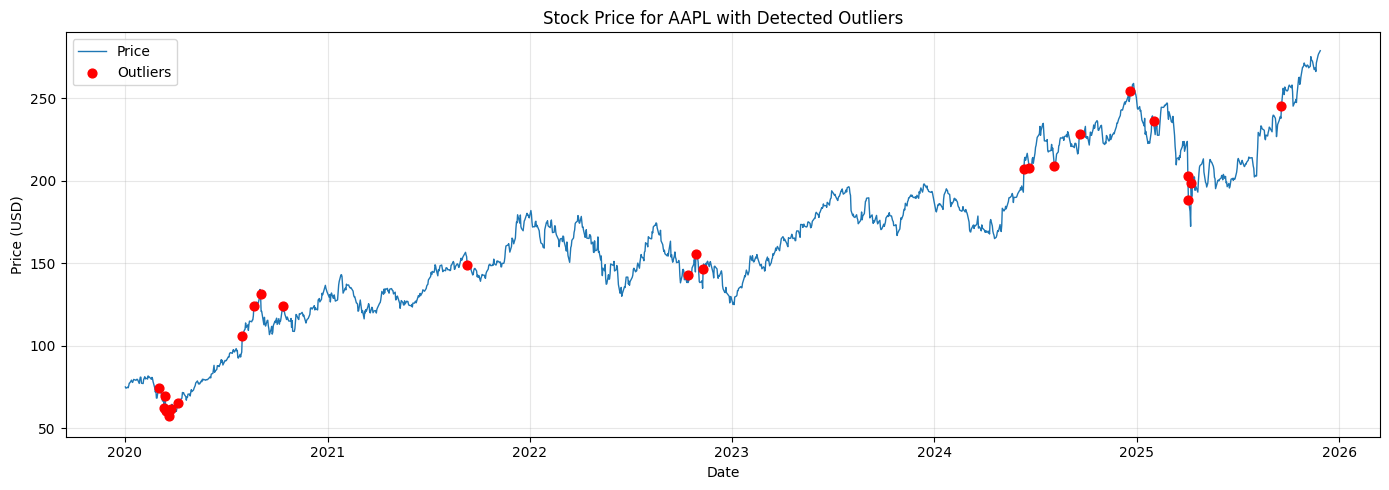

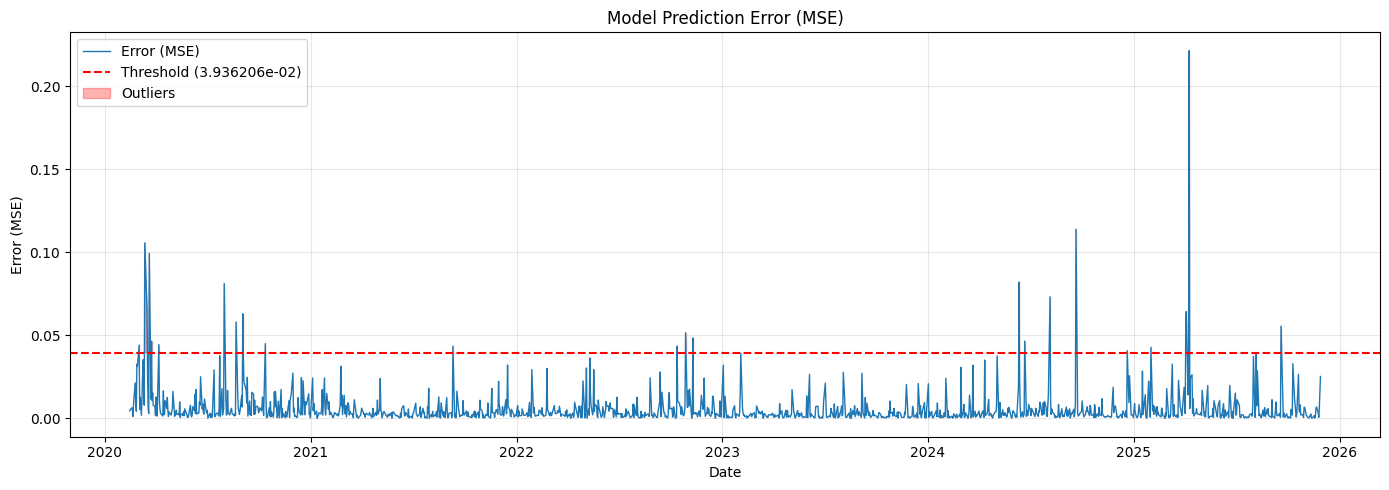

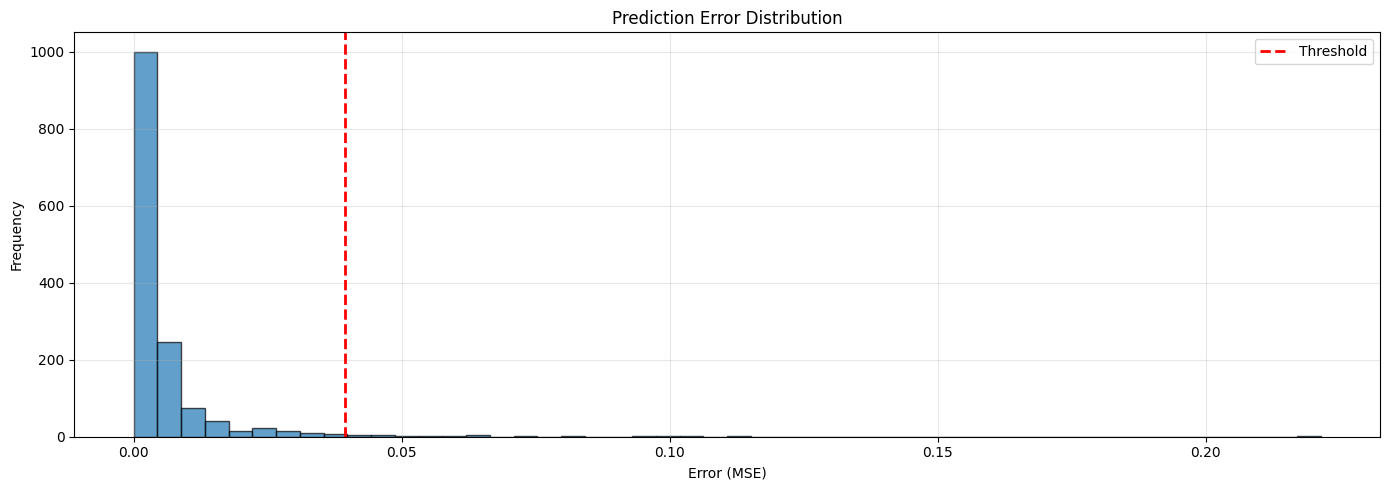

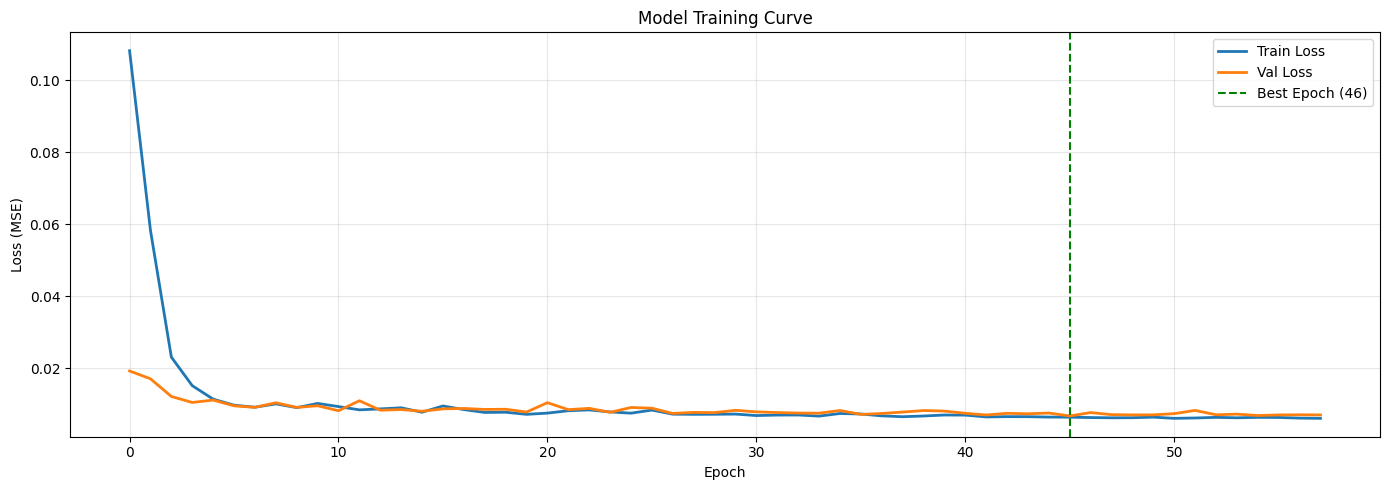

Completed.


In [ ]:
stock_data = download_stock_data(TICKER, START_DATE, END_DATE)

if stock_data.shape[0] < SEQUENCE_LENGTH + 10:
    raise RuntimeError("Insufficient data for the chosen sequence length.")

stock_data = engineer_features(stock_data)

feature_columns = ["Return", "HighLowSpread", "LogVolume"]
features_array = stock_data[feature_columns].values
dates_array = stock_data.index.values
prices_array = stock_data["Close"].values.reshape(-1, 1)

feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(features_array)

input_sequences, target_values = create_sequences_and_targets(
    scaled_features,
    SEQUENCE_LENGTH
)
print(
    f"Total sequences created: {input_sequences.shape[0]} | "
    f"Input shape: {input_sequences.shape[1:]} | "
    f"Target shape: {target_values.shape}"
)

dataset = TimeSeriesForecastDataset(input_sequences, target_values)

total_samples = len(dataset)
training_samples = int(total_samples * TRAIN_VALIDATION_SPLIT)
validation_samples = total_samples - training_samples

training_dataset, validation_dataset = random_split(
    dataset,
    [training_samples, validation_samples],
    generator=torch.Generator().manual_seed(SEED)
)

training_loader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"Training: {len(training_dataset)} sequences | Validation: {len(validation_dataset)} sequences")

input_dimension = input_sequences.shape[2]

model = ForecastLSTMAutoencoder(
    sequence_length=SEQUENCE_LENGTH,
    input_dimension=input_dimension,
    hidden_dimension=HIDDEN_DIM,
    latent_dimension=LATENT_DIM,
    number_of_layers=NUMBER_OF_LAYERS,
    dropout_rate=DROPOUT_RATE,
    number_of_heads=4
).to(device)

print(model)
total_parameters = sum(p.numel() for p in model.parameters())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: {total_parameters:,} | Trainable: {trainable_parameters:,}")

loss_criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

steps_per_epoch = max(1, len(training_loader))
total_steps = NUMBER_OF_EPOCHS * steps_per_epoch
maximum_learning_rate = LEARNING_RATE * 10

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=maximum_learning_rate,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy="linear"
)

training_losses, validation_losses, best_epoch = train_model(
    model,
    training_loader,
    validation_loader,
    NUMBER_OF_EPOCHS,
    EARLY_STOPPING_PATIENCE,
    device,
    optimizer,
    scheduler,
    loss_criterion
)

reconstruction_errors = compute_reconstruction_errors(
    model,
    input_sequences,
    target_values,
    device
)

outliers_mask, threshold = detect_outliers_lognormal(reconstruction_errors)

number_of_outliers = outliers_mask.sum()
outlier_percentage = number_of_outliers / len(outliers_mask) * 100.0

print(f"Threshold (lognormal, 3 sigma): {threshold:.6e}")
print(f"Outliers detected: {number_of_outliers} / {len(outliers_mask)} ({outlier_percentage:.2f}%)")

outlier_indices = np.where(outliers_mask)[0]
outlier_report = create_outlier_report(
    outlier_indices,
    dates_array,
    prices_array,
    reconstruction_errors,
    SEQUENCE_LENGTH
)
print("\nFirst detected outliers (up to 20):")
print(outlier_report.to_string(index=False))

print_error_statistics(reconstruction_errors)

save_model_artifacts(model, feature_scaler)

analyzer = dlfr.PlotOutlierAnalyzer(
    dates=dates_array,
    prices=prices_array,
    errors=reconstruction_errors,
    outliers_mask=outliers_mask,
    threshold=threshold,
    train_losses=training_losses,
    val_losses=validation_losses,
    best_epoch=best_epoch,
    seq_length=SEQUENCE_LENGTH
)

analyzer.plot_all(ticker=TICKER)

print("Completed.")

##**Fazendo a previsão com o modelo treinado**

In [ ]:
class OutlierPredictor:
    """
    Outlier predictor based on the reconstruction error of a trained model.

    Attributes:
        model: Trained model (ForecastLSTMAutoencoder or similar).
        threshold: Threshold used to classify outliers based on reconstruction error.
    """

    def __init__(self, model: nn.Module, threshold: float) -> None:
        """
        Initializes the outlier predictor.

        Args:
            model: Trained forecasting model.
            threshold: Reconstruction error threshold used to classify outliers.
        """
        self.model = model
        self.threshold = threshold
        self.model.eval()

    def _compute_error(
        self,
        input_tensor: torch.Tensor,
        target_tensor: torch.Tensor
    ) -> torch.Tensor:
        """
        Computes the mean squared error between model prediction and target.

        Args:
            input_tensor: Input sequence tensor.
            target_tensor: Target tensor.

        Returns:
            Tensor containing reconstruction errors.
        """
        with torch.no_grad():
            prediction = self.model(input_tensor)
            error = ((prediction - target_tensor) ** 2).mean(dim=-1)
        return error

    def single_prediction(
        self,
        input_sequence: torch.Tensor,
        target_value: torch.Tensor,
        return_details: bool = False
    ) -> Union[bool, Tuple[bool, dict]]:
        """
        Predicts whether a single data point is an outlier.

        Args:
            input_sequence: Input sequence with shape
                (sequence_length, input_dimension) or
                (1, sequence_length, input_dimension).
            target_value: Target value with shape
                (input_dimension,) or (1, input_dimension).
            return_details: If True, returns additional diagnostic information.

        Returns:
            If return_details=False:
                Boolean indicating whether the point is an outlier.
            If return_details=True:
                Tuple (is_outlier, details_dict).
        """
        if input_sequence.dim() == 2:
            input_sequence = input_sequence.unsqueeze(0)
        if target_value.dim() == 1:
            target_value = target_value.unsqueeze(0)

        error = self._compute_error(input_sequence, target_value)
        error_value = float(error.item())
        is_outlier = error_value > self.threshold

        if return_details:
            with torch.no_grad():
                prediction = self.model(input_sequence)

            details = {
                'reconstruction_error': error_value,
                'threshold': self.threshold,
                'anomaly_score': error_value / self.threshold,
                'prediction': prediction.squeeze(0).cpu().numpy(),
            }
            return is_outlier, details

        return is_outlier

    def batch_prediction(
        self,
        input_sequences: torch.Tensor,
        target_values: torch.Tensor,
        return_details: bool = False
    ) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        """
        Predicts outliers for a batch of samples.

        Args:
            input_sequences: Batch of input sequences with shape
                (n_samples, sequence_length, input_dimension).
            target_values: Target values with shape
                (n_samples, input_dimension).
            return_details: If True, returns additional diagnostic information.

        Returns:
            If return_details=False:
                Boolean NumPy array indicating outliers.
            If return_details=True:
                Tuple (outlier_mask, details_dict).
        """
        errors = self._compute_error(input_sequences, target_values)
        errors_np = errors.cpu().numpy()
        outlier_mask = errors_np > self.threshold

        if return_details:
            with torch.no_grad():
                predictions = self.model(input_sequences)

            details = {
                'reconstruction_errors': errors_np,
                'threshold': self.threshold,
                'anomaly_scores': errors_np / self.threshold,
                'predictions': predictions.cpu().numpy(),
                'outlier_indices': np.where(outlier_mask)[0],
                'num_outliers': int(outlier_mask.sum()),
            }
            return outlier_mask, details

        return outlier_mask

In [ ]:
predictor = OutlierPredictor(model=model, threshold=threshold)

In [ ]:
inputs, targets = next(iter(validation_loader))

is_outlier, details = predictor.single_prediction(
        inputs[0].to(device), targets[0].to(device), return_details=True
    )

In [ ]:
print(f"   Is outlier: {is_outlier}")
print(f"   Error: {details['reconstruction_error']:.4f}")
print(f"   Score: {details['anomaly_score']:.4f}")
print(f"   Threshold: {threshold:.4f}")

   Is outlier: False
   Error: 0.0029
   Score: 0.0732
   Threshold: 0.0394


In [ ]:
print("\n2. Batch Prediction:")
batch_input = inputs.to(device)
batch_target = targets.to(device)

outliers, details = predictor.batch_prediction(
    batch_input, batch_target, return_details=True
)
print(f"   Total samples: {len(outliers)}")
print(f"   Outliers detected: {details['num_outliers']}")
print(f"   Indices: {details['outlier_indices'][:5]}...")
print(f"   Threshold: {threshold:.4f}")


2. Batch Prediction:
   Total samples: 64
   Outliers detected: 2
   Indices: [19 25]...
   Threshold: 0.0394
